**Note**: You will need to download these 2 data files and save to the same folder as this code

- Mcdonald_review - 6 months - 40 stores.xlsx
- Mcdonald_review - 6 months - 40 stores_Manual Label.xlsx

**to delete this note before submission**

# ISSS609 Text Analytics and Applications - Group 1 
# McDonald’s – I’m Lovin’ It? Sentiment Analysis of McDonald’s Customer Reviews

## Table of Contents
1. [Introduction](#introduction)   
    1.1 [Dataset](#dataset)
2. [Exploratory Data Analysis](#exploratory-data-analysis)    
    2.1 [Data Distribution and Data Quality](#data-distribution)   
    2.2 [Univariate Analysis](#univariate-analysis)      
    2.3 [Bivariate Analysis](#bivariate-analysis)      
    2.4 [Bi-gram Analysis](#bigram-analysis)   
    2.5 [ Latent Dirichlet Allocation (LDA) for Topic Modeling](#lda-model)
3. [Pre-processing](#pre-processing)    
    3.1 [Handling Missing Data](#missing-data)    
    3.2 [Text Cleaning](#text-cleaning)    
    3.3 [Tokenization](#tokenization)     
    3.4 [Stop Words Removal](#stop-words-removal)    
    3.5 [Lemmatization](#lemmatization)    
    3.4 [Vectorization](#vectorization)
4. [Feature Engineering](#feature-engineering)     
5. [Final Dataset](#final-dataset)

<a name="introduction"></a>
# 1. Introduction
In this project, we aim to perform text analytics on the customer review data of McDonald’s restaurants across the United States (US) to develop a performance monitoring tool for the Country Restaurant Manager.

<a name = "dataset"></a>
## 1.1 Dataset 
The dataset of choice is McDonald’s Store Reviews (Elgiriyewithana, 2023), which contains over 33,000 anonymized reviews of McDonald’s restaurants in the US, scraped from Google reviews.     
Retrieved from: https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews

### Data Dictionary

|Column Name | Data Type | Description|  Example |  
| -- | -- | -- | -- |
|reviewer_id | int |  Unique identifier for each reviewer | 47 | 
|store_name | string |  Name of the restaurant | McDonald’s| 
|category | string | Type of the restaurant | Fast food restaurant | 
|store_address| string | Address of the restaurant being reviewed | 13749 US-183 Hwy, Austin, TX 78750, United States | 
|latitude | float |Latitude coordinate of the restaurant’s locations | 30.4607176 | 
|longtitude |float |Longitude coordinate of the restaurant’s locations | -97.7928744| 
|rating_count | string |Total number of reviews available for the restaurant | 1240 | 
|review_time | string |Time stamp indicating when the review was posted | 5 months ago | 
|review |string|Textual content of review provided by reviewer |Will not answer my call. Messed up my order 4times in an hour!|
|rating |string |Numeric rating given by reviewer (scale of 1 to 5) | 1 star | 
|sentiment |string |Sentiment of restaurant review (positive, negative, neutral) | negative| 

### 6 Months of Data
In order to ensure that our analysis reflects recent customer experiences, we will filter the dataset to include only reviews from the past six months. This allows us to focus on more current feedback, ensuring that the insights generated are relevant to the present operational and service conditions at McDonald's restaurants.

The analysis done in the rest of the notebook will focus on the reviews from the past 6 months.

## 1.2 Import Dataset

In [1]:
# !pip install textblob gensim contractions

In [2]:
# import packages
import pandas as pd
import datetime as dt
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns

import folium, contractions

from textblob import TextBlob
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords, words, wordnet
from nltk.util import ngrams
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.tokenize import word_tokenize

from gensim import corpora
from gensim.models.ldamodel import LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer

custom_colors = {'positive': '#87EBA8', 'neutral': '#909090', 'negative': '#F28268'}    # Green ; Gray ; Red 

[nltk_data] Downloading package stopwords to C:\Users\Sze
[nltk_data]     Min\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sze
[nltk_data]     Min\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sze
[nltk_data]     Min\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv("Mcdonald_review - 6 months - 40 stores.csv")
#remove spaces in column names
df.columns = df.columns.str.strip()
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,sentiment
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star,negative
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,positive
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star,negative
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was �����������...,5 stars,positive
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,negative


<a name="exploratory-data-analysis"></a>
# 2. Exploratory Data Analysis (EDA)

This section presents a comprehensive exploratory analysis of the dataset. The objective is to uncover key insights that will inform our modeling and further analysis. The EDA focuses on understanding the distribution of key variables, identifying patterns, correlations, and anomalies, and exploring relationships between features.    

These are the EDA techniques we employed:   
**1. Data Distribution and Data Quality**    
- **Review Count**
- **Inconsistencies between review wording and rating**
- **Location Analysis**

**2. Univariate Analysis**  
- **Sentiment Class Distribution**   
- **Word Count Distribution**
- **Word Frequency Analysis**
- **Word Cloud Generation**   

**3. Bivariate Analysis**   
**4. Bigram Analysis**   
**5. Latent Dirichlet Allocation (LDA) for Topic Modeling**    
**6. Inconsistencies between review wording and rating**

<a name="data-distribution"></a>
## 2.1 Data Distribution and Data Quality

### 2.1.1 Review Count

In [4]:
df_quality = df.copy()

# Count the total number of reviews
total_reviews = len(df_quality)
print(f'Total Number of Reviews: {total_reviews}')

Total Number of Reviews: 3492


In [5]:
# Check for duplicate reviews
duplicate_reviews = df_quality[df_quality.duplicated(subset=['store_address','review_time','review'], keep=False)]
print(f'Duplicate Reviews Found: {len(duplicate_reviews)}')

Duplicate Reviews Found: 1437


We note that there are numerous duplicate reviews, which we will address further on in the pre-processing step.

### 2.1.2 Inconsistencies between review wording and rating

In [6]:
df_quality[df_quality['reviewer_id'].isin([60])]

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,sentiment
26,60,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",4 months ago,"It was late, order was wrong, person taking or...",4 stars,positive


While customer reviews are typically accompanied by customer ratings (e.g. number of stars out of 5 stars), we noticed inconsistencies between ratings and review content. For instance, a customer may provide a 4-star rating, yet express negative sentiments in their review of the restaurant (as per the above example).

Such inconsistencies misrepresent the true sentiment to the management and could lead to suboptimal decisions regarding customer satisfaction and restaurant quality improvements. This further solidifies our proposed use case of leveraging sentiment analysis to mine insights into customer opinions directly from the reviews themselves, avoiding the risk of erroneous ratings.

## Manual Labelling

As noted in Sections 2.1.1 and 2.1.2, there are duplicate reviews inconsistencies across review-rating pairs. Thus, we have decided to drop the rating column and manually label the sentiment (positive, negative, or neutral) for each record of restaurant review, based on the review wording. A new column called ‘Final Sentiment’ is created to store the string values representing the corresponding sentiment. This feature will serve as the ground truth label for evaluating the performance of our sentiment analysis models.

### 2.1.3 Location Analysis

In [7]:
# Calculate the count of reviews per store
store_review_count = df_quality.groupby(['store_address', 'latitude', 'longitude']).size().reset_index(name='review_count')

# Create a map centered around the average location of the stores
map_center = [store_review_count['latitude'].mean(), store_review_count['longitude'].mean()]
mcdonalds_map = folium.Map(location=map_center, zoom_start=4)

# Add markers for each store, with Tooltip for hover effect
for _, row in store_review_count.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['review_count'] ** 0.5, 
        color='#DA291C', #red
        fill=True,
        fill_color='#FFC72C', #yellow
        fill_opacity=0.6,
        tooltip=folium.Tooltip(f"{row['review_count']} reviews, {row['store_address']}")  # Tooltip for hover effect
    ).add_to(mcdonalds_map)

# Save the map as an HTML file and display it
mcdonalds_map.save("mcdonalds_review_map_with_tooltip.html")

mcdonalds_map

Based on the distribution of the reviews, we note the following observations:
- **Clusters in Major Cities**: There are prominent clusters of stores with high review counts in major cities, including Los Angeles, New York, and Miami. These areas show the highest concentrations of reviews, which could be reflective of more foot traffic and larger customer bases.
- **Review Density in California and the East Coast**: The map highlights high review densities on the West Coast, particularly around Los Angeles, and along the East Coast, especially near New York and Washington, D.C..
- **Less Activity in Central U.S.**: In contrast, the central United States appears to have fewer stores with high review counts, as indicated by the smaller circles scattered across states like Texas and Arizona.

<a name="univariate-analysis"></a>
## 2.2. Univariate Analysis
Goal: Understand the distribution of individual features, such as sentiment labels and word frequencies. To also plot wordclouds to view content of reviews.

In [8]:
# Read in Correctly Labelled Data
df = pd.read_csv("Mcdonald_review - 6 months - 40 stores_Manual Label.csv")
df.columns = df.columns.str.strip()

df['actual_sentiment'] = df['Final Label']
df = df[df['actual_sentiment'] != "Duplicate"]
df = df[df['actual_sentiment'] != "??"]

### 2.2.1 Sentiment Class Distribution

In [9]:
df['Final Label'].value_counts()

Final Label
negative    1322
positive    1274
neutral      252
Name: count, dtype: int64

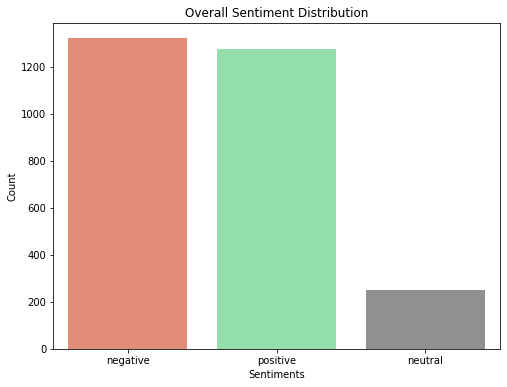

In [10]:
# Plot overall distribution of sentiments
plt.figure(figsize=(8, 6))
sns.countplot(
    x='actual_sentiment', 
    data=df, 
    order=df['actual_sentiment'].value_counts().index,
    hue='actual_sentiment', 
    palette=custom_colors,  
    legend=False  
)
plt.title('Overall Sentiment Distribution')
plt.ylabel('Count')
plt.xlabel('Sentiments')
plt.show()

The graph highlights that the dataset contains a relatively balanced distribution between positive and negative reviews, with neutral reviews being relatively less frequent. This could indicate that customers often have strong opinions, either positive or negative, about their McDonald's experiences, with fewer indifferent or neutral reviews.

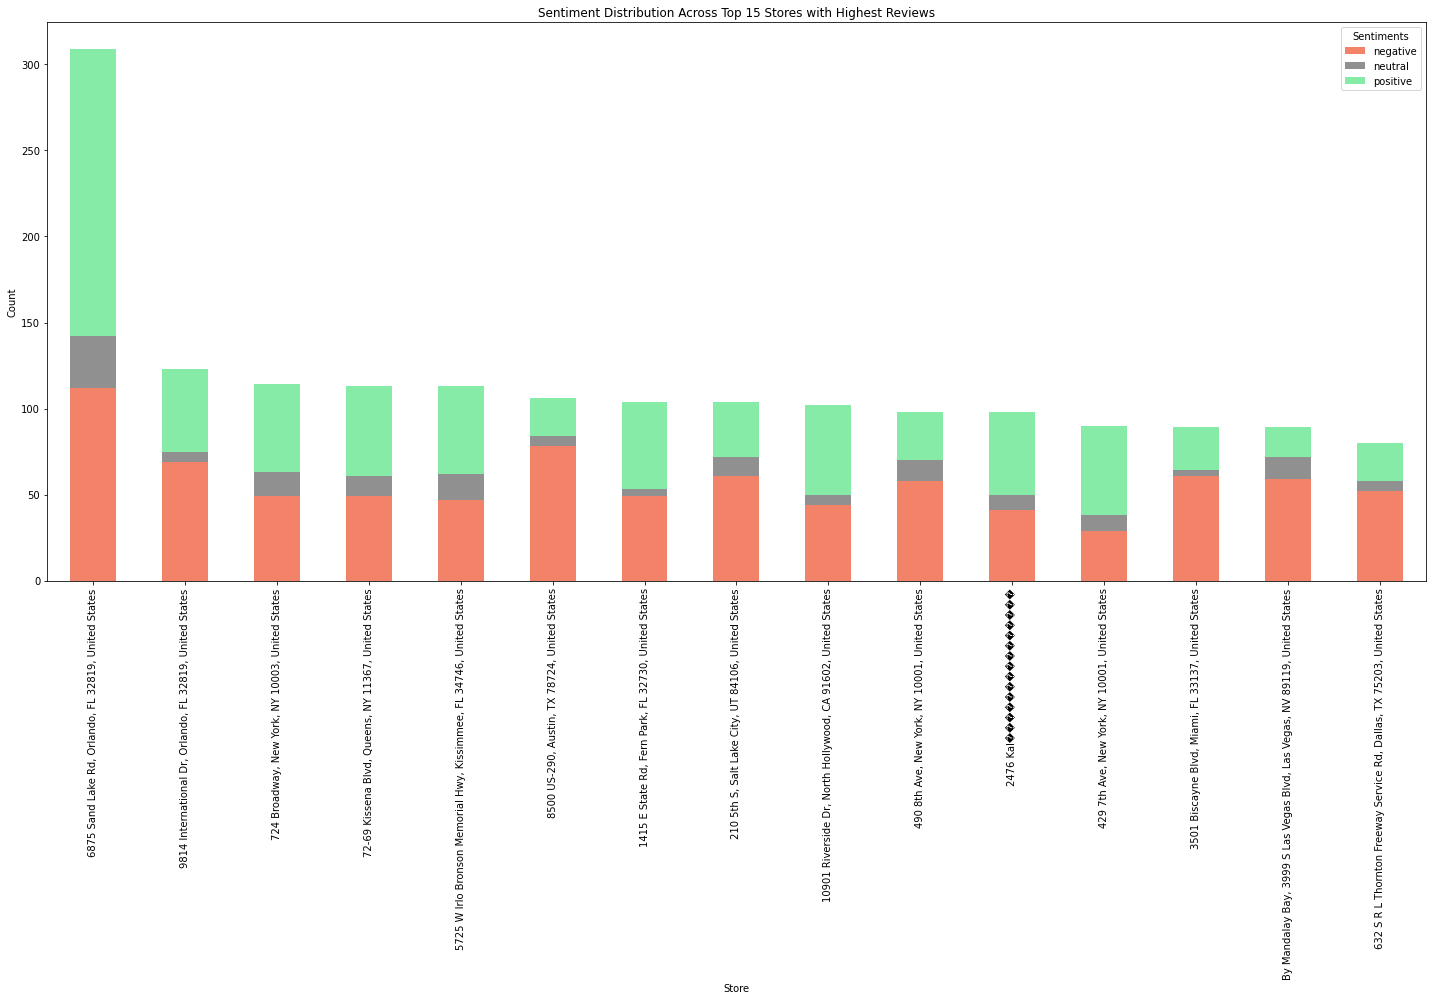

In [11]:
# Create a pivot table to count the occurrences of each sentiment per store
pivot_table = df.pivot_table(index='store_address', columns='actual_sentiment', aggfunc='size', fill_value=0)

# Calculate total reviews per store and sort based on that
pivot_table['total_reviews'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='total_reviews', ascending=False)

# Display only the top stores based on the number of reviews
top_stores = pivot_table.head(15)
top_stores = top_stores.drop(columns='total_reviews')

# Plot stacked bar chart for the top stores
top_stores.plot(kind='bar', stacked=True, figsize=(20, 14), color=custom_colors)

# Customize plot
plt.title('Sentiment Distribution Across Top 15 Stores with Highest Reviews')
plt.ylabel('Count')
plt.xlabel('Store')
plt.legend(title='Sentiments')
plt.tight_layout()
plt.show()

**Top Stores by Review Count:**   
The store at 6875 Sand Lake Rd, Orlando, FL has the highest number of total reviews, with a significant portion being positive reviews, followed by negative and a small number of neutral reviews.   

**Sentiment Distribution:**   
In general, positive reviews (green) tend to dominate across most stores, but there is a notable proportion of negative reviews (red) as well.
The neutral sentiment (grey)is relatively low across all stores, indicating that customers are generally more likely to have either positive or negative opinions about their experience.

# 2.2.2 Word Count Distribution

In [12]:
# Add a column for word count
df_quality['word_count'] = df_quality['review'].apply(lambda x: len(x.split()))

# Display basic statistics for word count
print(df_quality['word_count'].describe())

count    3492.000000
mean       26.918385
std        38.126039
min         1.000000
25%         4.000000
50%        14.000000
75%        34.000000
max       380.000000
Name: word_count, dtype: float64


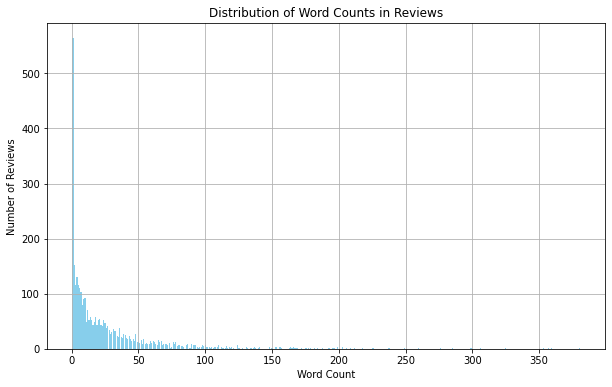

In [13]:
word_count_distribution = df_quality['word_count'].value_counts().sort_index(ascending=True)

# Plotting the word count distribution as a bar graph
plt.figure(figsize=(10, 6))
plt.bar(word_count_distribution.index, word_count_distribution.values, color='skyblue')

# Adding labels and title
plt.title('Distribution of Word Counts in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Number of Reviews')
plt.grid(True)

# Show the plot
plt.show()

The distribution of word counts in the reviews shows that a significant number of reviews contain just a single word. This is evident from the peak at the 1-word mark, where over 500 reviews have only one word. Such short reviews may provide limited insights and could impact the overall sentiment analysis. This suggests that a preprocessing step to either filter or handle these 1-word reviews may be necessary.

### 2.2.3 Word Frequency Analysis

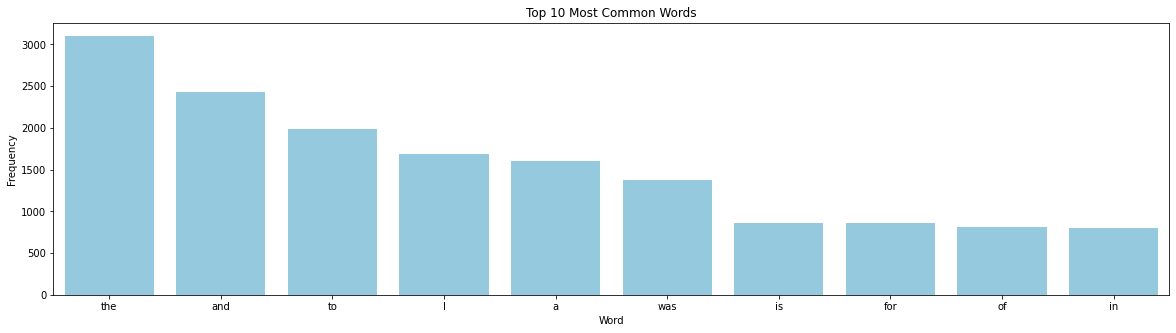

In [14]:
# Function to clean the text by removing non-alphabetic characters
def clean_text(text):
    # Remove punctuation and special characters using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

freq_analysis_df = df.copy()

# Apply the cleaning function to the 'review' column
freq_analysis_df['cleaned_review'] = freq_analysis_df['review'].apply(clean_text)

# Tokenize the cleaned reviews into words
freq_analysis_df['tokenized_review'] = freq_analysis_df['cleaned_review'].apply(nltk.word_tokenize)

# Flatten all tokens into a single list
all_words = [word for tokens in freq_analysis_df['tokenized_review'] for word in tokens]

# Count the frequency of words
word_freq = Counter(all_words)

# Get the top 10 most common words
most_common_words = word_freq.most_common(10)

# Convert to DataFrame for plotting
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot the most common words
plt.figure(figsize=(20, 5))
sns.barplot(x='Word', y='Frequency', data=common_words_df, color='skyblue')
plt.title('Top 10 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

Without removal of any words, the top 10 most common words are not very indicative of any sentiment or review content. To further analyse the content of the reviews, we consider removing stop-words for the word frequency analysis

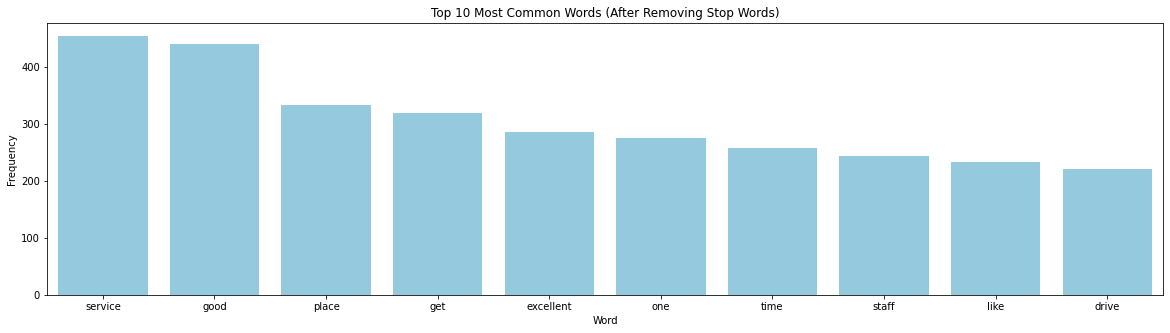

In [15]:
# Load stop words from NLTK
stop_words = set(stopwords.words('english'))
stop_words.update(['food', 'mcdonald', 'mcdonalds','order', 'location'])  # Add more common words to the stopwords list

# Function to clean text by removing non-alphabetic characters and stopwords
def clean_text(text):
    # Remove punctuation and special characters using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase and tokenize it
    words = nltk.word_tokenize(text.lower())
    # Remove stop words
    words = [word for word in words if word.lower() not in stop_words]
    return words

# Apply the cleaning function to the 'review' column
freq_analysis_df['cleaned_review'] = freq_analysis_df['review'].apply(clean_text)

# Flatten all tokens into a single list
all_words = [word for tokens in freq_analysis_df['cleaned_review'] for word in tokens]

# Count the frequency of words
word_freq = Counter(all_words)

# Get the top 10 most common words
most_common_words = word_freq.most_common(10)

# Convert to DataFrame for plotting
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot the most common words
plt.figure(figsize=(20, 5))
sns.barplot(x='Word', y='Frequency', data=common_words_df, color='skyblue')
plt.title('Top 10 Most Common Words (After Removing Stop Words)')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

This new graph provides a better view of the content of the reviews.

### Kara TO DO: Vocabulary and Slang

In [16]:
standard_words = set(words.words())

# Convert to a set for faster lookups and unique vocabulary
vocabulary = set(all_words)

# Identify slang or uncommon words by checking against the standard English words
slang_words = [word for word in vocabulary if word.lower() not in standard_words]

# Display the identified slang or uncommon words
#print("Potential Slang or Uncommon Words:")
#print(slang_words)

### 2.2.4. Word Cloud Generation

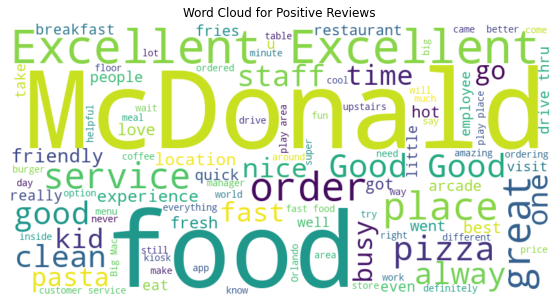

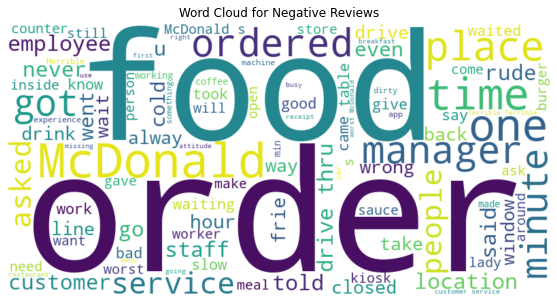

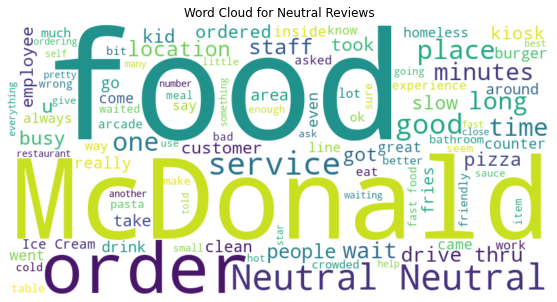

In [17]:
# Function to generate word clouds for each sentiment
def generate_wordcloud(sentiment):
    text = ' '.join(df[df['sentiment'] == sentiment]['review'])
    wordcloud = WordCloud(width=800, height=400, max_words=100,
                           background_color='white', colormap='viridis'                          
                         ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Reviews')
    plt.axis('off')
    plt.show()

# Generate word clouds for positive, negative, and neutral reviews
generate_wordcloud('positive')
generate_wordcloud('negative')
generate_wordcloud('neutral')

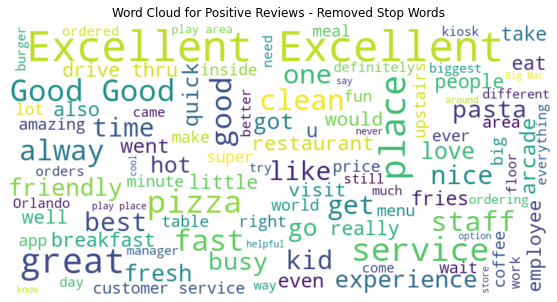

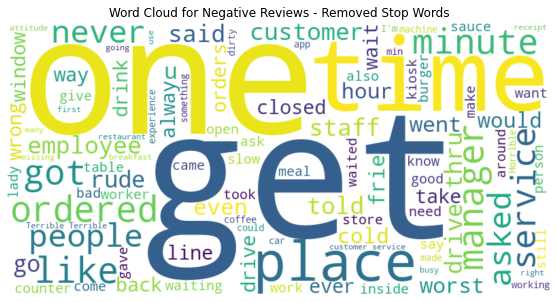

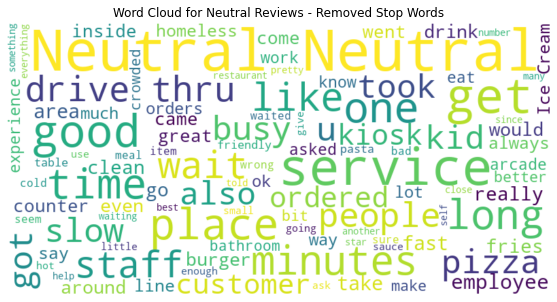

In [18]:
# Function to generate word clouds for each sentiment
def generate_wordcloud(sentiment):
    text = ' '.join(df[df['sentiment'] == sentiment]['review'])
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        max_words=100, 
        stopwords=stop_words,  # Remove stopwords and custom words
        background_color='white', 
        colormap='viridis'  # Optional: Set the colormap
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Reviews - Removed Stop Words')
    plt.axis('off')
    plt.show()

# Generate word clouds for positive, negative, and neutral reviews
generate_wordcloud('positive')
generate_wordcloud('negative')
generate_wordcloud('neutral')

These were the observations from the word cloud:     
**Positive** reviews, we note words such as *excellent* and *good* which are expected of positive reviews.
<br><br>
**Negative** reviews contain words such as *time, service* and *manager* which could be an indication of issues that the customer has with the restaurant.
<br><br>
**Neutral** reviews contain more generic words such as *neutral, service*. However, we note that there are similarities to negative reviews, in particular the words *slow, service* and *minutes* suggesting that many neutral reviews may express mildly negative sentiments.

<a name="bivariate-analysis"></a>
## 2.3 Bivariate Analysis
Goal: Understand the relationship between review features (e.g., length of the review and sentiment).

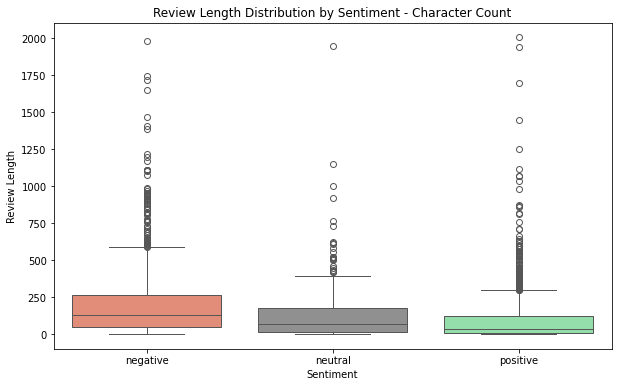

In [19]:
# Create a column for review length
bivariate_df = df.copy()
bivariate_df['review_length'] = bivariate_df['review'].apply(len)

# Plot the distribution of review lengths by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', 
            data=bivariate_df, 
            hue='sentiment', palette=custom_colors)
plt.title('Review Length Distribution by Sentiment - Character Count')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

**Negative** reviews tend to have the longest review lengths, with a median review length around 200 characters. There are also several outliers where review lengths go as high as 2000 characters. This suggests that customers who leave negative reviews tend to write longer reviews, possibly to elaborate more on their dissatisfaction.
<br><br>
**Positive** reviews have a similar median review length as negative reviews, but fewer extreme outliers. The bulk of the positive reviews is shorter, hovering around 150-200 characters.
This could imply that positive reviews are more concise, but there are still customers who write longer reviews to describe positive experiences.
<br><br>
**Neutral** reviews generally have the shortest review lengths compared to both positive and negative reviews, with a median review length just below 200 characters.
This indicates that neutral reviews tend to be shorter, which makes sense as customers who feel neutral about their experience may not feel the need to elaborate as much.

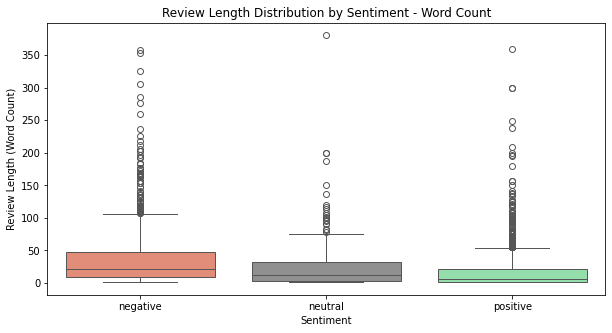

In [20]:
# Create a column for word count instead of character count
bivariate_df['review_length'] = bivariate_df['review'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths by sentiment
plt.figure(figsize=(10, 5))
sns.boxplot(x='sentiment', y='review_length', 
            data=bivariate_df, 
            hue='sentiment', palette=custom_colors)
plt.title('Review Length Distribution by Sentiment - Word Count')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Word Count)')
plt.show()

A similar relationship (as noted in the character count) between the count of words and the Sentiment can be noted for the word count.

<a name="bigram-analysis"></a>
## 2.4 Bigrams Analysis
Goal: Understand the distribution of individual features, such as sentiment labels and word frequencies.

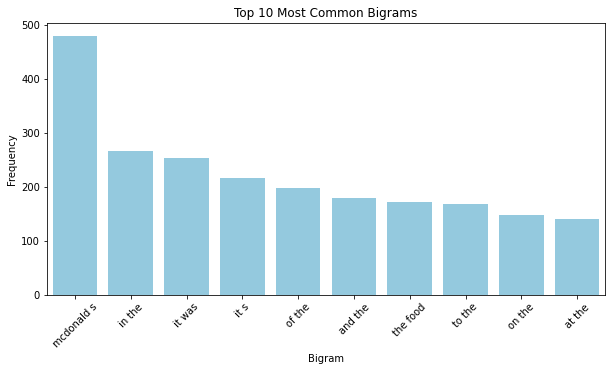

In [21]:
# Function to clean tokens by removing non-alphabetic characters
def clean_tokens(tokens):
    cleaned_tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens] 
    cleaned_tokens = [token.lower() for token in cleaned_tokens if token]  
    return cleaned_tokens

# Function to extract bigrams from cleaned tokens
def get_bigrams(tokens):
    bigrams = ngrams(tokens, 2)
    return [' '.join(gram) for gram in bigrams]

# Apply the cleaning function and get bigrams for each review
bigram_df = df.copy()
bigram_df['tokenized_review'] = bigram_df['review'].apply(nltk.word_tokenize)
bigram_df['cleaned_review'] = bigram_df['tokenized_review'].apply(clean_tokens)  
bigram_df['bigrams'] = bigram_df['cleaned_review'].apply(get_bigrams)  

# Flatten all bigrams into a single list
all_bigrams = [bigram for bigrams in bigram_df['bigrams'] for bigram in bigrams]

# Count the frequency of bigrams
bigram_freq = Counter(all_bigrams)

# Get the top 10 most common bigrams
most_common_bigrams = bigram_freq.most_common(10)

# Convert to DataFrame for plotting
common_bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
sns.barplot(x='Bigram', y='Frequency', data=common_bigrams_df, color='skyblue')
plt.title('Top 10 Most Common Bigrams')
plt.xticks(rotation=45)
plt.show()

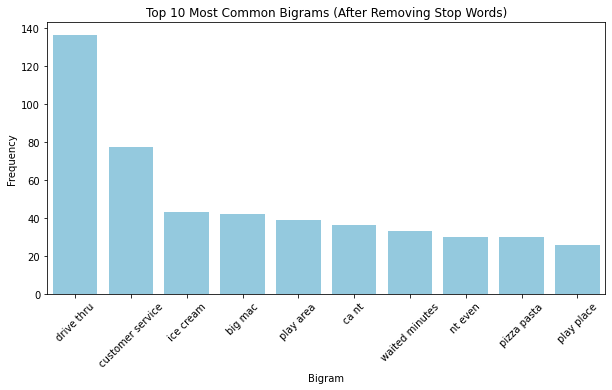

In [22]:
# Function to clean tokens by removing non-alphabetic characters and stopwords
def clean_tokens(tokens):
    cleaned_tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]  # Remove non-alphabetic characters
    cleaned_tokens = [token.lower() for token in cleaned_tokens if token and token.lower() not in stop_words]  # Remove empty tokens and stopwords
    return cleaned_tokens

# Function to extract bigrams from cleaned tokens
def get_bigrams(tokens):
    bigrams = ngrams(tokens, 2)
    return [' '.join(gram) for gram in bigrams]

# Apply the cleaning function and get bigrams for each review
bigram_df = df.copy()
bigram_df['tokenized_review'] = bigram_df['review'].apply(nltk.word_tokenize)
bigram_df['cleaned_review'] = bigram_df['tokenized_review'].apply(clean_tokens)  
bigram_df['bigrams'] = bigram_df['cleaned_review'].apply(get_bigrams)

# Flatten all bigrams into a single list
all_bigrams = [bigram for bigrams in bigram_df['bigrams'] for bigram in bigrams]

# Count the frequency of bigrams
bigram_freq = Counter(all_bigrams)

# Get the top 10 most common bigrams
most_common_bigrams = bigram_freq.most_common(10)

# Convert to DataFrame for plotting
common_bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
sns.barplot(x='Bigram', y='Frequency', data=common_bigrams_df, color='skyblue')
plt.title('Top 10 Most Common Bigrams (After Removing Stop Words)')
plt.xticks(rotation=45)
plt.show()

The bigrams are now more meaningful as common stop words (e.g., "the", "and", "of", etc.) have been removed, which provides more insights to the contents of the reviews.

<a name="lda-model"></a>
## 2.5 Latent Dirichlet Allocation (LDA) for Topic Modeling

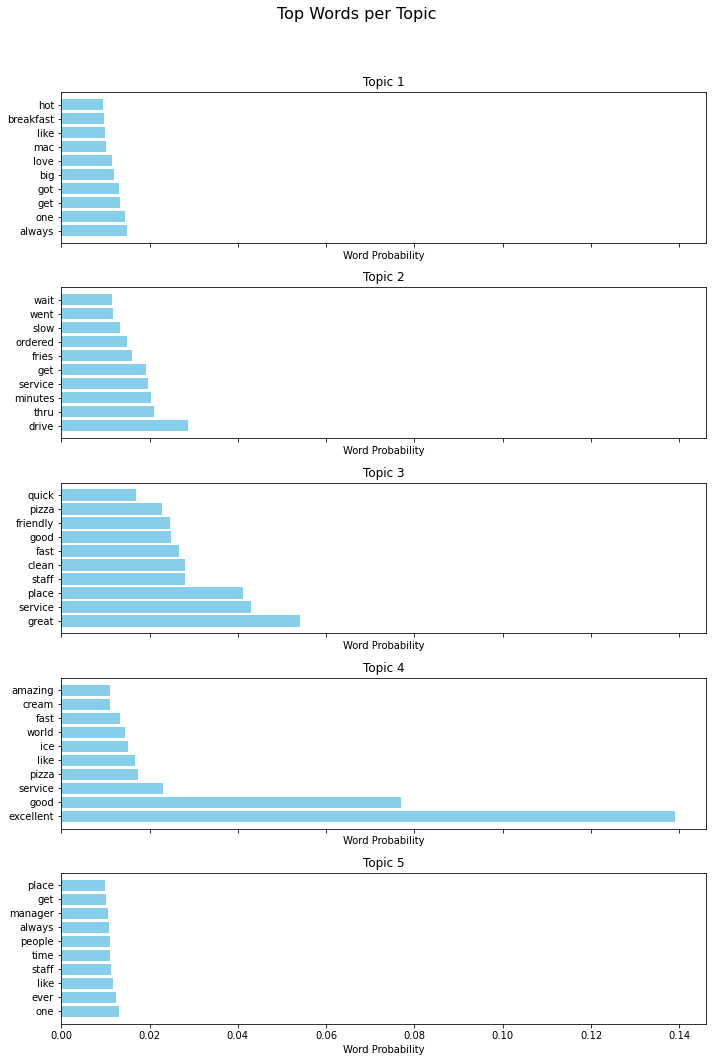

In [23]:
lda_df = df.copy()

# Function to preprocess each review
def preprocess_review(review):
    # Tokenize and lowercase
    tokens = word_tokenize(review.lower())
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return tokens

# Apply preprocessing to all reviews
lda_df['processed_review'] = lda_df['review'].apply(preprocess_review)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(lda_df['processed_review'])

# Filter out rare and common tokens
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(review) for review in lda_df['processed_review']]

num_topics = 5
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)

# Function to plot the top words in each topic
def plot_top_words_per_topic(lda_model, num_words=10):
    topics = lda_model.show_topics(formatted=False, num_words=num_words)
    
    fig, axes = plt.subplots(len(topics), 1, figsize=(10, 15), sharex=True)
    fig.suptitle('Top Words per Topic', fontsize=16)
    
    for i, topic in topics:
        ax = axes[i]
        words, probs = zip(*topic)
        ax.barh(words, probs, color='skyblue')
        ax.set_title(f'Topic {i+1}')
        ax.set_xlabel('Word Probability')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Plot the top 10 words for each topic
plot_top_words_per_topic(lda_model, num_words=10)

**Topic 1:**   
Top words: good, food, service, terrible, place   
Interpretation: This topic seems to focus on general customer experiences, combining both positive (e.g., "good," "food") and negative sentiments (e.g., "terrible," "place"). It may reflect mixed reviews on overall dining experiences at McDonald's, focusing on food and service quality.   
**Topic 2:**      
Top words: fries, nuggets, ordered, chicken, time   
Interpretation: This topic is more specific to food items like fries, nuggets, and chicken. Customers may be discussing their ordering experiences and commenting on specific food items. The mention of "time" could also suggest concerns with preparation or delivery speed.   
**Topic 3:**   
Top words: order, drive, thru, manager, service   
Interpretation: This topic revolves around ordering and drive-thru experiences. Words like "drive," "thru," "order," and "manager" suggest that many reviews discuss interactions at the drive-thru or with management, potentially related to customer service issues.   
**Topic 4:**   
Top words: service, staff, clean, friendly, fast   
Interpretation: This topic focuses on service and staff behavior. The positive words like "clean," "friendly," and "fast" suggest that customers are discussing cleanliness and staff performance, likely indicating satisfaction or dissatisfaction with these aspects.   
**Topic 5:**
Top words: rude, slow, service, order, food   
Interpretation: This topic clearly centers on negative experiences. Words like "rude," "slow," and "service" indicate that this topic contains reviews where customers express dissatisfaction, particularly related to staff behavior and service delays.   

**Findings:**
- Service-related topics dominate: The most common themes across the topics involve service and staff behavior, highlighting that customers frequently review their experience with McDonald’s staff.   
- Food quality is a key concern: Many reviews focus on food quality (e.g., words like "good," "fries," "nuggets," and "chicken"). This suggests food-related complaints or compliments are significant for customers.   
- Operational issues are also important: Terms like "order," "drive-thru," "slow," and "minutes" suggest that many reviews revolve around operational issues such as wait times, drive-thru experiences, and service speed.    
- Negative experiences with staff: Words like "rude" and "slow" in some topics point to dissatisfaction with customer service, implying that staff behavior and response times are key factors in negative reviews.   

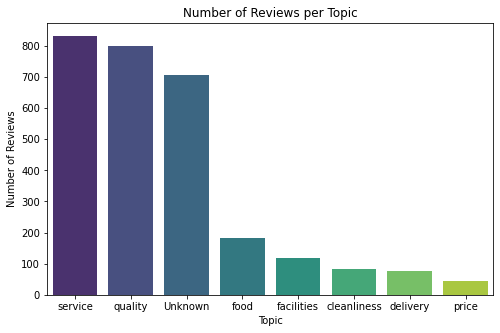

In [24]:
# Define the topic keyword lists (for classification)
topics_keywords = {
    'service': ['service', 'professional', 'unprofessional', 'staff', 'customer', 'support', 'help', 'rude', 'polite', 'friendly', 'slow', 'fast', 'wait', 'slowest'],
    'quality': ['quality', 'good', 'bad', 'excellent', 'fantastic', 'terrible', 'poor', 'great', 'worst'],
    'price': ['price', 'expensive', 'cheap', 'worth', 'money', 'cost', 'value'],
    'delivery': ['delivery', 'order', 'arrive', 'time', 'late', 'fast', 'delay'],
    'cleanliness': ['clean', 'dirty', 'messy', 'hygiene', 'bathroom', 'toilet', 'restroom', 'smell'],
    'food': ['cold', 'delicious', 'yummy', 'spoilt', 'disgusting', 'food', 'burger', 'pie', 'chicken', 'meal', 'fries', 'fish', 'frappe', 'nugget', 'soda'],
    'facilities': ['play', 'thru', 'drive']
}

# Function to classify a review based on topic keywords
def classify_review(review, keywords_dict):
    review_words = set(review)  # Convert review words to a set for faster lookups
    topic_scores = {topic: 0 for topic in keywords_dict}  # Initialize score for each topic
    
    # Count matches for each topic based on the keywords
    for topic, keywords in keywords_dict.items():
        for word in keywords:
            if word in review_words:
                topic_scores[topic] += 1
    
    # Determine the topic with the highest score (or return "Unknown" if no matches)
    best_topic = max(topic_scores, key=topic_scores.get)
    
    # If no matches, classify as "Unknown" or set a threshold for classification
    if topic_scores[best_topic] == 0:
        return 'Unknown'
    return best_topic

# Classify each review based on the predefined keywords
lda_df['topic'] = lda_df['processed_review'].apply(lambda x: classify_review(x, topics_keywords))

topic_counts = lda_df['topic'].value_counts()

# Plot the number of reviews for each topic
plt.figure(figsize=(8, 5))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis', hue=topic_counts.index,)
plt.title('Number of Reviews per Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.show()

The bar chart shows that:

- **Service** is the most frequently mentioned topic, followed by **quality**.
- A significant portion of reviews fell under the **"Unknown"** category, which could mean that the reviews do not match the predefined keyword categories or are too ambiguous.
- Topics like **food, delivery, and facilities** are also frequently discussed but less so compared to service and quality.

<a name="pre-processing"></a>
# 3. Pre-processing
This section outlines the various pre-processing methods applied to the raw text data to prepare it for further analysis and modeling. Effective pre-processing is essential for cleaning and structuring the text, ensuring consistency, and reducing noise, which ultimately improves model performance. 

These were the pre-processing steps taken to prepare the data for modelling.   
**1. Handle Missing Data**   
**2. Text Cleaning**    
**3. Tokenization**    
**4. Stop Words Removal**   
**5. Lemmatization**    
**6. Vectorization**

<a name="missing-data"></a>
## 3.1 Handling Missing Data
Handle any missing or null entries in the dataset, either by removing them or imputing with appropriate values.

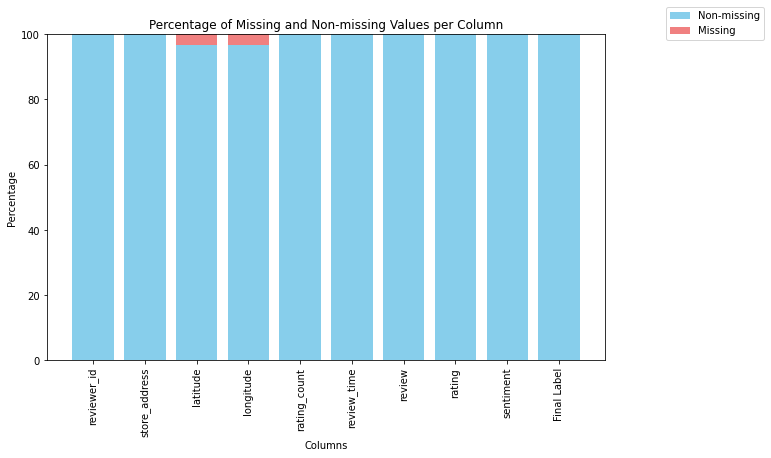

In [25]:
def plot_missing_data(df):
    #  the proportion of missing and non-missing values per column
    missing_df = df.iloc[:, list(range(0, 9)) + [12]]
    missing_percentage = missing_df.isnull().mean() * 100
    non_missing_percentage = 100 - missing_percentage

    # Create a DataFrame for plotting
    missing_data = pd.DataFrame({
        'Missing': missing_percentage,
        'Non-missing': non_missing_percentage
    })

    # Plot the 100% stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plot non-missing values
    ax.bar(missing_data.index, missing_data['Non-missing'], label='Non-missing', color='skyblue')
    # Plot missing values on top of non-missing values
    ax.bar(missing_data.index, missing_data['Missing'], bottom=missing_data['Non-missing'], label='Missing', color='lightcoral')

    # Add labels and title
    plt.xticks(rotation=90)
    plt.xlabel('Columns')
    plt.ylabel('Percentage')
    plt.title('Percentage of Missing and Non-missing Values per Column')
    plt.legend(bbox_to_anchor=(1.1, 1.1))

    # Show plot
    plt.show()

plot_missing_data(df)

In [26]:
df[df['latitude'].isna()]['store_address'].unique()

array(['2476 Kal���������������'], dtype=object)

We note that there are **101** missing values for latitude and longitude, which have a Store Address value of 2476 Kal��...    
To handle this unknown store, we will remove this store from the dataset.

In [27]:
df = df[df['store_address'] != '2476 Kal���������������']
df.iloc[:, list(range(0, 9)) + [12]].isna().value_counts()

reviewer_id  store_address  latitude  longitude  rating_count  review_time  review  rating  sentiment  Final Label
False        False          False     False      False         False        False   False   False      False          2750
Name: count, dtype: int64

This effectively removes the null values from the latitude and longtitude columns.

<a name="text-cleaning"></a>
## 3.2 Text Cleaning
- Convert text to lowercase to eliminate case-sensitivity issues.
- Expand contractions (e.g., "can't" to "cannot") to standardize the text.
- Remove special characters, numbers, and punctuation that do not contribute to the overall meaning of the text.

In [28]:
# Function for text cleaning
def clean_text(text):
   
    # Expand contractions
    text = contractions.fix(text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r"[^a-zA-Z\s']", '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the cleaning function to the 'review' column
df['cleaned_review'] = df['review'].apply(clean_text)

# Display the first few rows of the updated DataFrame
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,0 Stars no spaghetti,stars no spaghetti
1,"$28 for 2 med smoothie, 2 mcgriddle plain san...",for med smoothie mcgriddle plain sandwich whic...
2,1 star because I can't put 0,star because i cannot put
3,"10 minutes late opening, employees laughing wh...",minutes late opening employees laughing while ...
4,10/10 not recommended. Waited for our food for...,not recommended waited for our food for over m...


<a name="tokenization"></a>
## 3.3 Tokenization
Process of splitting the text into individual words or tokens which is an essential step before any further operations like stop word removal, stemming, or lemmatization, because the text needs to be in smaller units prior to processing it.

In [29]:
# Tokenize the text (split into individual words)
def tokenize_text(text):
    return text.split() 

# Apply tokenization
df['tokenized_review'] = df['cleaned_review'].apply(tokenize_text)

# Display tokenized reviews
df[['cleaned_review', 'tokenized_review']].head()

,cleaned_review,tokenized_review
0,stars no spaghetti,"[stars, no, spaghetti]"
1,for med smoothie mcgriddle plain sandwich whic...,"[for, med, smoothie, mcgriddle, plain, sandwic..."
2,star because i cannot put,"[star, because, i, cannot, put]"
3,minutes late opening employees laughing while ...,"[minutes, late, opening, employees, laughing, ..."
4,not recommended waited for our food for over m...,"[not, recommended, waited, for, our, food, for..."


<a name="stop-words-removal"></a>
## 3.4 Stop Words Removal
Eliminate common words (such as "the", "and", "is") that do not contribute significantly to the meaning of the text. Removing them reduces the noise in the data.

In [30]:
# Get English stop words
stop_words_final = set(stopwords.words('english'))

# Add more common words to the stopwords list
stop_words_final.update(['food', 'mcdonald', 'mcdonalds','order', 'location', "mcdonald's"])  

# View stop words
stop_words_list = list(stop_words_final)[:50]
print(f"These are the first 50 stopwords: {stop_words_list}")

These are the first 50 stopwords: ['it', 'yourself', 'to', 'for', 'down', 'can', 'some', 'most', 'if', "wouldn't", 'my', "it's", 'was', 'you', 't', 'wasn', 'between', 've', 'now', 'no', 'this', 'whom', "you'd", 'into', 'shan', 'very', "needn't", 's', "hadn't", 'after', 'have', 're', 'mcdonalds', 'will', 'is', 'only', "shouldn't", 'so', 'themselves', 'they', 'theirs', "you're", 'where', 'not', 'again', "hasn't", 'isn', 'both', 'ours', 'what']


In [31]:
# Function to remove stop words
def remove_stop_words(tokens):
    return [word for word in tokens if word.lower() not in stop_words_final]

# Apply stop word removal
df['filtered_review'] = df['tokenized_review'].apply(remove_stop_words)

# Display the reviews after stop words removal
df[['tokenized_review', 'filtered_review']].head()

,tokenized_review,filtered_review
0,"[stars, no, spaghetti]","[stars, spaghetti]"
1,"[for, med, smoothie, mcgriddle, plain, sandwic...","[med, smoothie, mcgriddle, plain, sandwich, fi..."
2,"[star, because, i, cannot, put]","[star, cannot, put]"
3,"[minutes, late, opening, employees, laughing, ...","[minutes, late, opening, employees, laughing, ..."
4,"[not, recommended, waited, for, our, food, for...","[recommended, waited, minutes, didnt, even, re..."


<a name="lemmatization"></a>
## 3.5 Lemmatization
Lemmatization is a more advanced process that reduces words to their dictionary form, ensuring the correct base form (e.g., "better" becomes "good").   

In the case of McDonald's reviews, we chose to only use Lemmatization due to the following reasons: 

**Accuracy and Context:**   
Reviews often contain a wide range of vocabulary, including both formal and informal language, and may feature irregular words (e.g., "better", "best", "good"). Lemmatization takes the context of words into account, ensuring that words are reduced to their meaningful base form.   

**Sentiment Analysis:**   
Lemmatization helps by preserving the intended meaning of words.   
For example, in a review like "The fries were better today", lemmatization will reduce "better" to "good", whereas stemming might not recognize the positive sentiment as accurately.

**Handling Complex Words:**
Reviews often include various verb tenses, plural forms, and comparative adjectives, which lemmatization can handle effectively, e.g. "Running" → "Run"   
Stemming, on the other hand, might reduce "running" to "runn", or fail to correctly identify more complex forms.   

**Real Words for Reporting:**   
When performing analysis on reviews, it’s often important to present findings using real, recognizable words. Lemmatization always returns dictionary-based words, whereas stemming can produce non-standard root forms that may not make sense in reports or visualizations.   

In [32]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Example function for lemmatization
def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['lemmatized_review'] = df['filtered_review'].apply(lemmatize_text)

# Display the reviews after stemming and lemmatization
df[['filtered_review', 'lemmatized_review']].head()

,filtered_review,lemmatized_review
0,"[stars, spaghetti]","[star, spaghetti]"
1,"[med, smoothie, mcgriddle, plain, sandwich, fi...","[med, smoothie, mcgriddle, plain, sandwich, fi..."
2,"[star, cannot, put]","[star, cannot, put]"
3,"[minutes, late, opening, employees, laughing, ...","[minute, late, opening, employee, laughing, li..."
4,"[recommended, waited, minutes, didnt, even, re...","[recommended, waited, minute, didnt, even, rec..."


<a name="vectorization"></a>
## 3.6 Vectorization
To convert the text into a numerical format that machine learning models can understand.    
Vectorization transforms the text into numbers. In our case, we have chosen to use TF-IDF (Term Frequency-Inverse Document Frequency) due to the following reasons:


**Focus on Important Words:**
TF-IDF assigns higher weight to words that are frequent in a single document (review) but less frequent across the entire collection of reviews. This is important because common words like "the", "food", "order" etc. might appear in many reviews and carry less importance in distinguishing between reviews.   

**Reducing the Impact of Common Words:**
TF-IDF counteracts this by giving less weight to common words, allowing the model to focus on terms that help differentiate the reviews.

**Sparse Data Handling:**
Reviews often contain a large number of words, but each individual review only uses a subset of these words. TF-IDF creates a sparse matrix where most values are zero (i.e., the word does not appear in the review), and it efficiently handles this sparse data.

In [33]:
# Combine tokens back into a string for vectorization
df['token_review_clean'] = df['lemmatized_review'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Apply vectorization
tfidf_matrix = vectorizer.fit_transform(df['token_review_clean'])

# Convert the TF-IDF matrix to a DataFrame (optional, to visualize the numerical representation)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display the first few rows of the TF-IDF DataFrame
tfidf_df.sort_values(by='ability', ascending=False)

,ability,abit,able,abruptly,absolute,absolutely,absurdity,abusing,abusive,abysmal,...,youre,yous,youtube,yuck,yum,yummy,yup,zero,zombie,zoo
786,0.199258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1741,0.092189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1846,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1845,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1829,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
920,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
921,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a name="feature-engineering"></a>
# 4. Feature Engineering
This section outlines the additional features we added to support our analysis.

## 4.1 Location

In [34]:
postal_code_pattern = r'\b[A-Z]{2}\s(\d{5})\b' # 2 letters and 5 digits 
                                               # Requires the 2 letters first so addresses that start with 5 digits 
                                               # are not picked up

# Function to extract postal code from the store address
def extract_postal_code(address):
    match = re.search(postal_code_pattern, address)
    return match.group(1) if match else None

# Apply the function to the 'store_address' column and create a new 'location' column
df.loc[:, 'location'] = df['store_address'].apply(extract_postal_code)

In [35]:
# Generate a Store ID based on the unique store_address, starting from 1
df.loc[:, 'store_id'] = pd.factorize(df['store_address'])[0] + 1

# Display the DataFrame with the new Store ID column
df.iloc[:, list(range(0, 9)) + [12]].head()

,reviewer_id,store_address,latitude,longitude,rating_count,review_time,review,rating,sentiment,Final Label
0,30918,"9814 International Dr, Orlando, FL 32819, Unit...",28.423814,-81.461242,"5,468",6 months ago,0 Stars no spaghetti,1 star,negative,negative
1,13731,"6875 Sand Lake Rd, Orlando, FL 32819, United S...",28.450387,-81.471414,"19,671",a week ago,"$28 for 2 med smoothie, 2 mcgriddle plain san...",3 stars,neutral,negative
2,22129,"By Mandalay Bay, 3999 S Las Vegas Blvd, Las Ve...",36.090244,-115.175822,"2,365",4 weeks ago,1 star because I can't put 0,1 star,negative,negative
3,14040,"25200 I-10 Lot 2, San Antonio, TX 78257, Unite...",29.676267,-98.634580,"1,460",5 months ago,"10 minutes late opening, employees laughing wh...",1 star,negative,negative
4,13784,"6875 Sand Lake Rd, Orlando, FL 32819, United S...",28.450387,-81.471414,"19,671",2 weeks ago,10/10 not recommended. Waited for our food for...,1 star,negative,negative


<a name="final-dataset"></a>
<br><br>
# 5. Final Dataset

In [36]:
final_df = df[['store_address', 'location', 'reviewer_id', 'review_time','actual_sentiment',
                'review', 'token_review_clean']]

final_df = final_df.sort_values(by=['location', 'actual_sentiment'])

final_df = final_df.drop_duplicates(subset=['store_address', 'review_time', 'actual_sentiment','review'])

final_df.head()

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean
185,"621 Broadway, Newark, NJ 07104, United States",07104,19164,5 days ago,negative,Every single time I order on Uber eats or Door...,every single time uber eats doordash even go d...
187,"621 Broadway, Newark, NJ 07104, United States",07104,27527,6 days ago,negative,Every single time I order on Uber eats or Door...,every single time uber eats doordash even go d...
271,"621 Broadway, Newark, NJ 07104, United States",07104,19183,3 months ago,negative,Horrible service from the night shift manager ...,horrible service night shift manager would als...
350,"621 Broadway, Newark, NJ 07104, United States",07104,19162,2 weeks ago,negative,I only eat at this specific location when I do...,eat specific dont time travel elsewhere newark...
449,"621 Broadway, Newark, NJ 07104, United States",07104,19165,3 weeks ago,negative,It sucks because this place does have good sta...,suck place good staff there also staff doesnt ...


In [37]:
# Set display option to show full text
pd.set_option('display.max_colwidth', None)

final_df.loc[[185,187], :]

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean
185,"621 Broadway, Newark, NJ 07104, United States",07104,19164,5 days ago,negative,"Every single time I order on Uber eats or DoorDash or even go to the Drive thru, part of my order is missing. I call to speak to the manager and all I get is attitude. This is an issue as not always do these delivery app���������������������������s refund you. Or to drive back isn���������������������������t something you can always do.\n\nAs someone who was manager at one of the top McDonald���������������������������",every single time uber eats doordash even go drive thru part missing call speak manager get attitude issue always delivery apps refund drive back isnt something always someone manager one top
187,"621 Broadway, Newark, NJ 07104, United States",07104,27527,6 days ago,negative,"Every single time I order on Uber eats or DoorDash or even go to the Drive thru, part of my order is missing. I call to speak to the manager and all I get is attitude. This is an issue as not always do these delivery app���������������������������s refund you. Or to drive back isn���������������������������t something you can always do.\n\nAs someone who was manager at one of the top McDonald���������������������������",every single time uber eats doordash even go drive thru part missing call speak manager get attitude issue always delivery apps refund drive back isnt something always someone manager one top


In [38]:
final_df.isna().value_counts()

store_address  location  reviewer_id  review_time  actual_sentiment  review  token_review_clean
False          False     False        False        False             False   False                 2539
Name: count, dtype: int64

In [39]:
print(f"The final dataset contains {len(final_df)} rows and {len(final_df.columns)} columns.")

The final dataset contains 2539 rows and 7 columns.


## Export to Excel for Modeling

In [40]:
final_df.to_csv("cleaned_data.csv", index=False)

tfidf_df.to_csv("tfidf_df.csv", index=False)

print("Both files exported for Modeling.")

Both files exported for Modeling.


---